#Data Proccesing

In [5]:
# Download the dataset
!kaggle datasets download -d noamsegal/affectnet-training-data

import zipfile

with zipfile.ZipFile("affectnet-training-data.zip", "r") as zip_ref:
    zip_ref.extractall("affectnet_data")

Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
affectnet-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import pandas as pd

# Load the CSV
data = pd.read_csv("affectnet_data/labels.csv")

# FIrst lines
print(data.head())
print(data.columns)

# Distribution of the emotions
print(data['label'].value_counts())

   Unnamed: 0                     pth     label    relFCs
0           0  anger/image0000006.jpg  surprise  0.873142
1           1  anger/image0000060.jpg     anger  0.852311
2           2  anger/image0000061.jpg     anger  0.800957
3           3  anger/image0000066.jpg   disgust  0.843079
4           4  anger/image0000106.jpg     anger  0.849108
Index(['Unnamed: 0', 'pth', 'label', 'relFCs'], dtype='object')
label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64


In [7]:
import os
import cv2
import numpy as np

# Dataset path
base_dir = "affectnet_data/"

# Mapping
class_mapping = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'surprise': 3,
    'fear': 4,
    'disgust': 5,
    'anger': 6,
    'contempt': 7
}

# Load images and labels
def load_images_from_folders(base_dir, class_mapping, target_size=(48, 48)):# 48 for Computer resources
    X = []
    y = []
    for class_name, class_idx in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load images
            img = cv2.imread(img_path)
            if img is not None:
                # RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Redimension and normalization
                img = cv2.resize(img, target_size)
                img = img / 255.0
                X.append(img)
                y.append(class_idx)
    return np.array(X), np.array(y)

# Load images and labels again
X, y = load_images_from_folders(base_dir, class_mapping)

# Shapes
print("X Shape (images):", X.shape)
print("Y shape(etiquetas):", y.shape)

X Shape (images): (29042, 48, 48, 3)
Y shape(etiquetas): (29042,)


In [8]:
from sklearn.model_selection import train_test_split

# Training and testing split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Shapes
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de validación:", X_val.shape)
print("Tamaño de prueba:", X_test.shape)

Tamaño de entrenamiento: (23233, 48, 48, 3)
Tamaño de validación: (2904, 48, 48, 3)
Tamaño de prueba: (2905, 48, 48, 3)


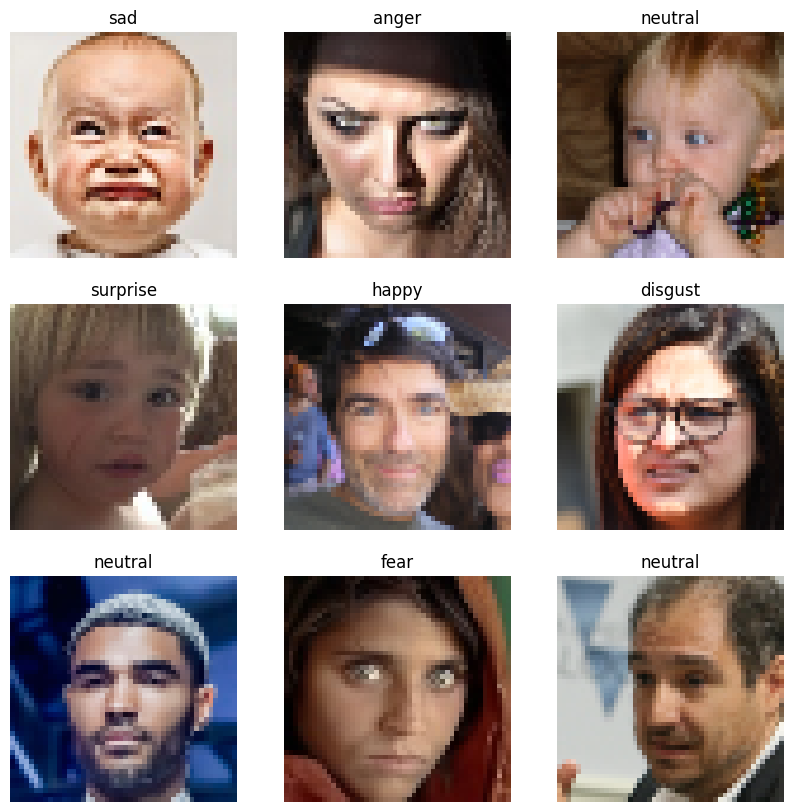

In [9]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(list(class_mapping.keys())[y_train[i]])
    plt.axis("off")
plt.show()

#CNN AFFECTNET

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:

# Custom architecture
def create_custom_cnn(classes):
    model = Sequential()

    # Block 1  Convolution
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))  # 3 chanels for RGB
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))#Pooling
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten the features
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Output [Neutral, Happy...]
    model.add(Dense(classes, activation='softmax'))

    # Model compilation
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Model creation
num_classes = 8  # Num of classes
model = create_custom_cnn(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 594,888 (2.27 MB)

 Trainable params: 592,392 (2.26 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [53]:
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

#Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#Application
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

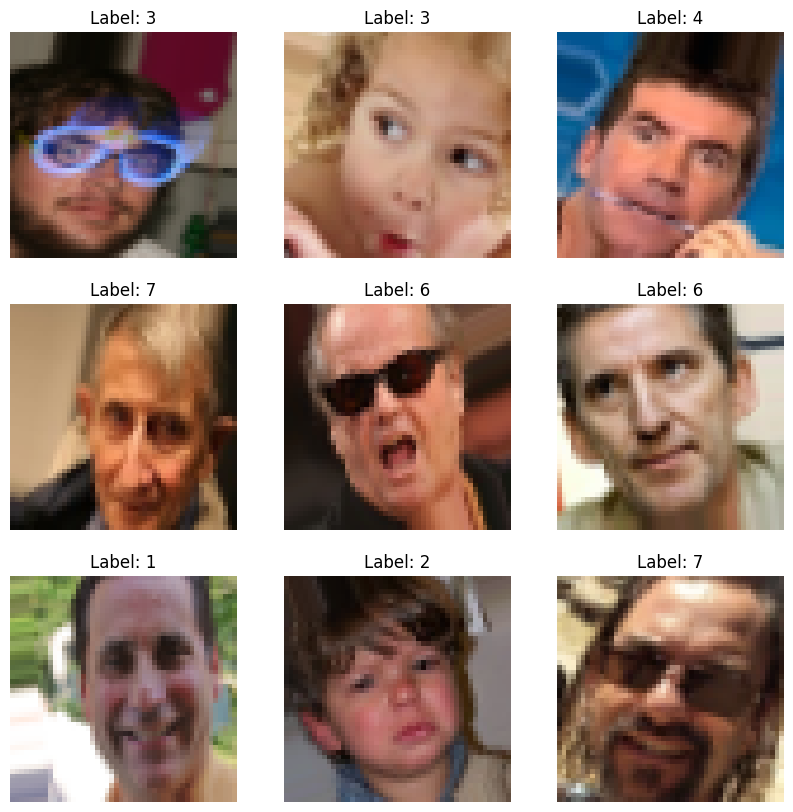

In [56]:
# Visualization
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()

In [57]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Weights:", class_weights_dict)

# Model training
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=30,
    class_weight=class_weights_dict
)

Weights: {0: 0.7008023648648649, 1: 0.7222394926635165, 2: 1.1916803446860895, 3: 0.893576923076923, 4: 1.1251937233630376, 5: 1.4801860346585116, 6: 1.1442572892040976, 7: 1.2626630434782609}
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


364/364 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.5590 - loss: 1.2620 - val_accuracy: 0.5917 - val_loss: 1.0854
Epoch 2/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.5693 - loss: 1.2360 - val_accuracy: 0.5966 - val_loss: 1.0747
Epoch 3/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.5680 - loss: 1.2276 - val_accuracy: 0.5429 - val_loss: 1.1800
Epoch 4/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.5755 - loss: 1.2117 - val_accuracy: 0.6196 - val_loss: 1.0205
Epoch 5/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.5818 - loss: 1.2046 - val_accuracy: 0.4926 - val_loss: 1.4205
Epoch 6/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.5781 - loss: 1.2128 - val_accuracy: 0.5718 - val_loss: 1.1235
Epoch 7/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.5747 - loss: 1.2022 - val_accuracy: 0.6258 - val_loss: 0.9939
Epoch 8/30
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.5724 - loss: 1.2151 - val_accurac

In [58]:
# Model evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss in test set: {test_loss:.4f}")
print(f"Accuaracy on test set: {test_accuracy:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6420 - loss: 0.9570
Loss in test set: 0.9438
Accuaracy on test set: 0.6482


In [59]:
model.save('recognition_modelconv2d.h5')

In [64]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar el modelo en Google Drive
model.save('/content/drive/MyDrive/recognition_modelconv2d.h5')

Mounted at /content/drive


In [65]:
model.save('/content/drive/MyDrive/recognition_model.keras')

In [37]:
#from tensorflow.keras.models import load_model
#model = load_model('emotion_recognition_model.h5')

In [60]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Select the class with bigest probability

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


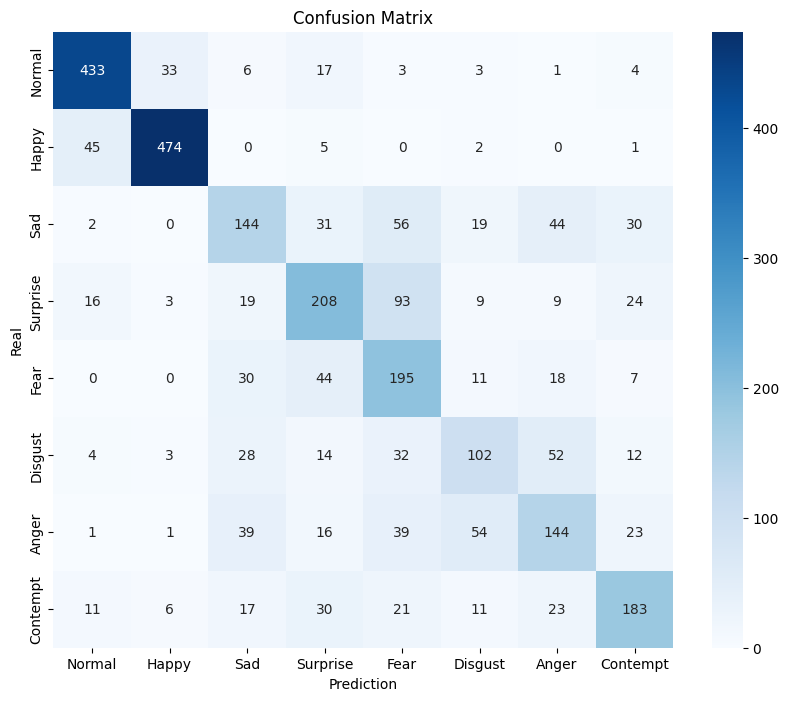


Clasification Report:

              precision    recall  f1-score   support

      Normal       0.85      0.87      0.86       500
       Happy       0.91      0.90      0.91       527
         Sad       0.51      0.44      0.47       326
    Surprise       0.57      0.55      0.56       381
        Fear       0.44      0.64      0.52       305
     Disgust       0.48      0.41      0.45       247
       Anger       0.49      0.45      0.47       317
    Contempt       0.64      0.61      0.62       302

    accuracy                           0.65      2905
   macro avg       0.61      0.61      0.61      2905
weighted avg       0.65      0.65      0.65      2905



In [61]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
labels = ['Normal', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.show()

# Reporte detallado de clasificación
print("\nClasification Report:\n")
classification_report_text = classification_report(y_test, y_pred_classes, target_names=labels)
print(classification_report_text)